# Import Libraries

In [1]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [ ]:
device

# Generalized Matrix Factoring (GMF)—Linear model

![](GMF_architecture.png)

### Model Architecture

In [4]:
class GMF(nn.Module):
    def __init__(self,items_size,users_size,embedding_dim):
        super(GMF, self).__init__()
        self.items_embedding = nn.Embedding(items_size,embedding_dim)
        self.users_embedding = nn.Embedding(users_size,embedding_dim)

    def forward(self,items,users):
        item_vector = self.items_embedding(items)
        user_vector = self.users_embedding(users)
        mul_vector=user_vector*item_vector
        return torch.sigmoid(torch.sum(mul_vector,dim=1))

### Initializing Model

In [8]:
GMF_model=GMF(227,666536,50).to(device)
GMF_model.load_state_dict(torch.load("../models/GMF_model.pth"))
GMF_model.eval()


/tmp/ipykernel_130957/1609326625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GMF_model.load_state_dict(torch.load("../models/GMF_model.pth"))


GMF(
  (items_embedding): Embedding(227, 50)
  (users_embedding): Embedding(666536, 50)
)

### training

In [10]:
with open("../reports/GMF_train_report.json","r") as f:
    GMF_train_report = json.load(f)

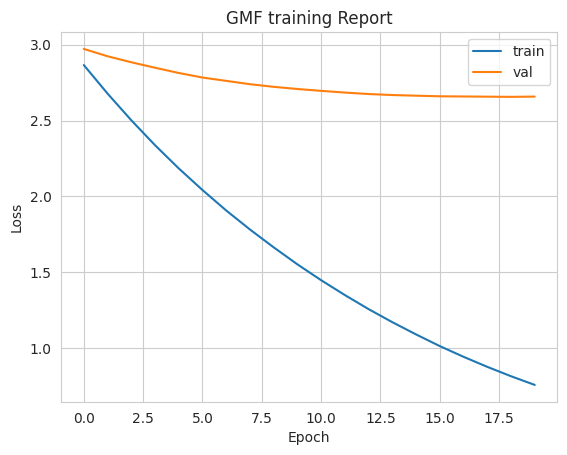

In [13]:
plt.title("GMF training Report")
plt.plot(GMF_train_report["train_loss"])
plt.plot(GMF_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#  HybMLP model

![](HybMLP_architecture.png)

In [11]:
class HybMLP(nn.Module):
    def __init__(self, num_items,num_users, items_embedding_dim,users_embedding_dim,hidden_layers_size=(50,50,50,50),dropout_prob=(0.25,0.25,0.25),output_size=1):
        super(HybMLP,self).__init__()
        self.item_embedding = nn.Embedding(num_embeddings=num_items,embedding_dim=items_embedding_dim)
        self.user_embedding = nn.Embedding(num_embeddings=num_users,embedding_dim=users_embedding_dim)
        self.hidden_layer1 = nn.Linear(in_features=items_embedding_dim+users_embedding_dim+358, out_features=hidden_layers_size[0])
        self.dropout1 = nn.Dropout(dropout_prob[0])
        self.hidden_layer2=nn.Linear(in_features=hidden_layers_size[0],out_features=hidden_layers_size[1])
        self.dropout2 = nn.Dropout(dropout_prob[1])

        self.hidden_layer3=nn.Linear(in_features=hidden_layers_size[1],out_features=hidden_layers_size[2])
        self.dropout3 = nn.Dropout(dropout_prob[2])

        self.hidden_layer4=nn.Linear(in_features=hidden_layers_size[2],out_features=hidden_layers_size[3])
        self.dropout4 = nn.Dropout(dropout_prob[3])

        self.output_layer = nn.Linear(in_features=hidden_layers_size[3],out_features=output_size)

    def forward(self,x1,x2,x3):
        item_vector=self.item_embedding(x1)
        user_vector=self.user_embedding(x2)
        concatenation=torch.cat((item_vector, user_vector, x3), dim=1)

        first_hidden=self.hidden_layer1(concatenation)
        dropout_output1=self.dropout1(first_hidden)
        relu1=F.relu(dropout_output1)

        second_hidden=self.hidden_layer2(relu1)
        dropout_output2=self.dropout2(second_hidden)
        relu2=F.relu(dropout_output2)

        third_hidden=self.hidden_layer3(relu2)
        dropout_output3=self.dropout3(third_hidden)
        relu3=F.relu(dropout_output3)

        forth_hidden=self.hidden_layer4(relu3)
        dropout_output4=self.dropout4(forth_hidden)
        relu4=F.relu(dropout_output4)

        output=self.output_layer(relu4)
        return torch.sigmoid(output)

### Initializing model

In [21]:
HybMLP_model=HybMLP(num_items=227,num_users=666536,items_embedding_dim= 20,users_embedding_dim=100,hidden_layers_size=(64,132,16,6),dropout_prob=(0.75,0.75,0.5,0.75)).to(device)
HybMLP_model.load_state_dict(torch.load("../models/HybMLP_model.pth"))
HybMLP_model.eval()

/tmp/ipykernel_132776/3124233106.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  HybMLP_model.load_state_dict(torch.load("../models/HybMLP_model.pth"))


HybMLP(
  (item_embedding): Embedding(227, 20)
  (user_embedding): Embedding(666536, 100)
  (hidden_layer1): Linear(in_features=478, out_features=30, bias=True)
  (dropout1): Dropout(p=0.75, inplace=False)
  (hidden_layer2): Linear(in_features=30, out_features=10, bias=True)
  (dropout2): Dropout(p=0.75, inplace=False)
  (hidden_layer3): Linear(in_features=10, out_features=20, bias=True)
  (dropout3): Dropout(p=0.75, inplace=False)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

### training

In [43]:
with open("../reports/HyMLP_train_report.json","r") as f:
    HybMLP_train_report = json.load(f)

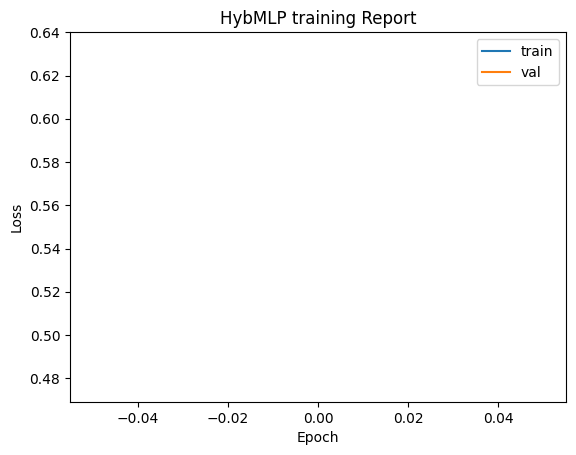

In [44]:
plt.title("HybMLP training Report")
plt.plot(HybMLP_train_report["train_loss"])
plt.plot(HybMLP_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Neural Hybrid Filtering
![](NHybF_architecture.png)

In [ ]:
class NHybF(nn.Module):
    def __init__(self, num_items,num_users, items_embedding_dim,users_embedding_dim,gmf_embedding_dim,hidden_layers_size=(50,50,50,50),dropout_prob=(0.25,0.25,0.25,0.25),output_size=1):
        super(NHybF,self).__init__()
        # HybMLP architecture part
        self.item_embedding = nn.Embedding(num_embeddings=num_items,embedding_dim=items_embedding_dim)
        self.user_embedding = nn.Embedding(num_embeddings=num_users,embedding_dim=users_embedding_dim)
        self.hidden_layer1 = nn.Linear(in_features=items_embedding_dim+users_embedding_dim+358, out_features=hidden_layers_size[0])
        self.dropout1 = nn.Dropout(dropout_prob[0])
        self.hidden_layer2=nn.Linear(in_features=hidden_layers_size[0],out_features=hidden_layers_size[1])
        self.dropout2 = nn.Dropout(dropout_prob[1])

        self.hidden_layer3=nn.Linear(in_features=hidden_layers_size[1],out_features=hidden_layers_size[2])
        self.dropout3 = nn.Dropout(dropout_prob[2])

        self.hidden_layer4=nn.Linear(in_features=hidden_layers_size[2],out_features=hidden_layers_size[3])
        self.dropout4 = nn.Dropout(dropout_prob[3])

        self.HybMLP_output_layer = nn.Linear(in_features=hidden_layers_size[3],out_features=output_size)


        # GMF architecture part
        self.items_embedding1 = nn.Embedding(num_items,gmf_embedding_dim)
        self.users_embedding1 = nn.Embedding(num_users,gmf_embedding_dim)
        self.gmf_dropout = nn.Dropout(dropout_prob[4])

        self.output_layer=nn.Linear(in_features=output_size+gmf_embedding_dim,out_features=output_size)

    def forward(self,x1,x2,x3):
        item_vector=self.item_embedding(x1)
        user_vector=self.user_embedding(x2)
        concatenation=torch.cat((item_vector, user_vector, x3), dim=1)

        first_hidden=self.hidden_layer1(concatenation)
        dropout_output1=self.dropout1(first_hidden)
        relu1=F.relu(dropout_output1)

        second_hidden=self.hidden_layer2(relu1)
        dropout_output2=self.dropout2(second_hidden)
        relu2=F.relu(dropout_output2)

        third_hidden=self.hidden_layer3(relu2)
        dropout_output3=self.dropout3(third_hidden)
        relu3=F.relu(dropout_output3)

        forth_hidden=self.hidden_layer4(relu3)
        dropout_output4=self.dropout4(forth_hidden)
        relu4=F.relu(dropout_output4)

        HybMLP_output=self.HybMLP_output_layer(relu4)


        GMF_item_vector = self.items_embedding1(x1)
        GMF_user_vector = self.users_embedding1(x2)
        GMF_mul_vector=GMF_item_vector*GMF_user_vector
        GMF_output=self.gmf_dropout(GMF_mul_vector)

        concatenation=torch.cat((HybMLP_output, GMF_output), dim=1)

        output=self.output_layer(concatenation)

        return torch.sigmoid(output)

### Initialize model

In [ ]:
NHybF_model=NHybF(num_items=227,num_users=666536,items_embedding_dim= 20,users_embedding_dim=100,gmf_embedding_dim=30,hidden_layers_size=(64,132,16,6),                          dropout_prob=(0.75,0.75,0.5,0.75,0.75)).to(device)
NHybF_model.load_state_dict(torch.load("../models/NHybF_model.pth"))
NHybF_model.eval()

### training report

In [41]:
with open("../reports/NHybF_train_report.json","r") as f:
    NHybF_train_report = json.load(f)

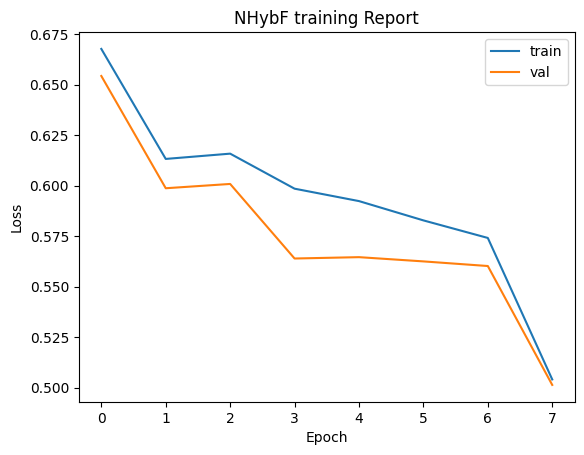

In [42]:
plt.title("NHybF training Report")
plt.plot(NHybF_train_report["train_loss"])
plt.plot(NHybF_train_report["val_loss"])
plt.legend(["train","val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()